read the file

In [1]:


# =====================================================
# FILE PATHS
# =====================================================
EMG_FILE = r"d:\UG_Proj\Human Sitting to Walking Transitions\S01\ExpData\EMG and IMU\stw4.csv"
MVC_HAM = r"d:\UG_Proj\Human Sitting to Walking Transitions\S01\ExpData\EMG and IMU\mvc_hamstrings.csv"
MVC_QUAD = r"d:\UG_Proj\Human Sitting to Walking Transitions\S01\ExpData\EMG and IMU\mvc_quadriceps.csv"
MVC_SHANK = r"d:\UG_Proj\Human Sitting to Walking Transitions\S01\ExpData\EMG and IMU\mvc_shank.csv"



In [2]:
def prRed(text):
    print(f'\033[91m{text}\033[0m')

def prGreen(text):
    print(f'\033[92m{text}\033[0m')

def prYellow(text):
    print(f'\033[93m{text}\033[0m')

def prBlue(text):
    print(f'\033[94m{text}\033[0m')

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

# Configuration of sensors based on file structure
emg_config = {
    0: {"name": "Tibialis Anterior", "fs": 1259},
    7: {"name": "Gastrocnemius Medialis", "fs": 1778},
    8: {"name": "Gastrocnemius Lateralis", "fs": 1778},
    15: {"name": "Rectus Femoris", "fs": 1259},
    22: {"name": "Vastus Lateralis", "fs": 1778},
    23: {"name": "Vastus Medialis", "fs": 1778},
    30: {"name": "Semitendinosus", "fs": 1259},
    37: {"name": "Bicep Femoris", "fs": 1259}
}

def butter_filters(data, fs, lowcut=20, highcut=450, lp_cutoff=6, order=4):
    nyq = 0.5 * fs
    # 1. Bandpass Filter (20-450 Hz)
    b_bp, a_bp = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    filtered = filtfilt(b_bp, a_bp, data)
    
    # 2. Rectification
    rectified = np.abs(filtered)
    
    # 3. Lowpass Filter (6 Hz) to obtain Linear Envelope
    b_lp, a_lp = butter(order, lp_cutoff/nyq, btype='low')
    envelope = filtfilt(b_lp, a_lp, rectified)
    return envelope

# Calculate Peaks from MVC files
mvc_files = [MVC_SHANK, MVC_HAM, MVC_QUAD]
peaks = {col: 0.0 for col in emg_config.keys()}

for mvc_file in mvc_files:
    df = pd.read_csv(mvc_file, skiprows=6, header=None)
    for col in emg_config.keys():
        data = pd.to_numeric(df[col], errors='coerce').dropna().values
        if len(data) > 0:
            env = butter_filters(data, emg_config[col]['fs'])
            peaks[col] = max(peaks[col], np.max(env))

# Process Main File and Normalize
df_stw = pd.read_csv(EMG_FILE, skiprows=2, header=None)
processed_results = {}

for col, info in emg_config.items():
    data_raw = pd.to_numeric(df_stw[col], errors='coerce').fillna(0).values
    env = butter_filters(data_raw, info['fs'])
    # Normalization: (Envelope / Peak) * 100
    processed_results[f"{info['name']} (%)"] = (env / peaks[col]) * 100

# Save final output
df_final = pd.DataFrame(processed_results)
df_final.to_csv('processed_normalized_emg.csv', index=False)

C:\Users\gupta\AppData\Local\Temp\ipykernel_17988\755662612.py:36: DtypeWarning: Columns (9,10,11,12,13,14,15,24,25,26,27,28,29,30,37,44,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(mvc_file, skiprows=6, header=None)
C:\Users\gupta\AppData\Local\Temp\ipykernel_17988\755662612.py:36: DtypeWarning: Columns (15,30,37,44,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(mvc_file, skiprows=6, header=None)
C:\Users\gupta\AppData\Local\Temp\ipykernel_17988\755662612.py:36: DtypeWarning: Columns (9,10,11,15,24,25,26,30,37,44,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(mvc_file, skiprows=6, header=None)


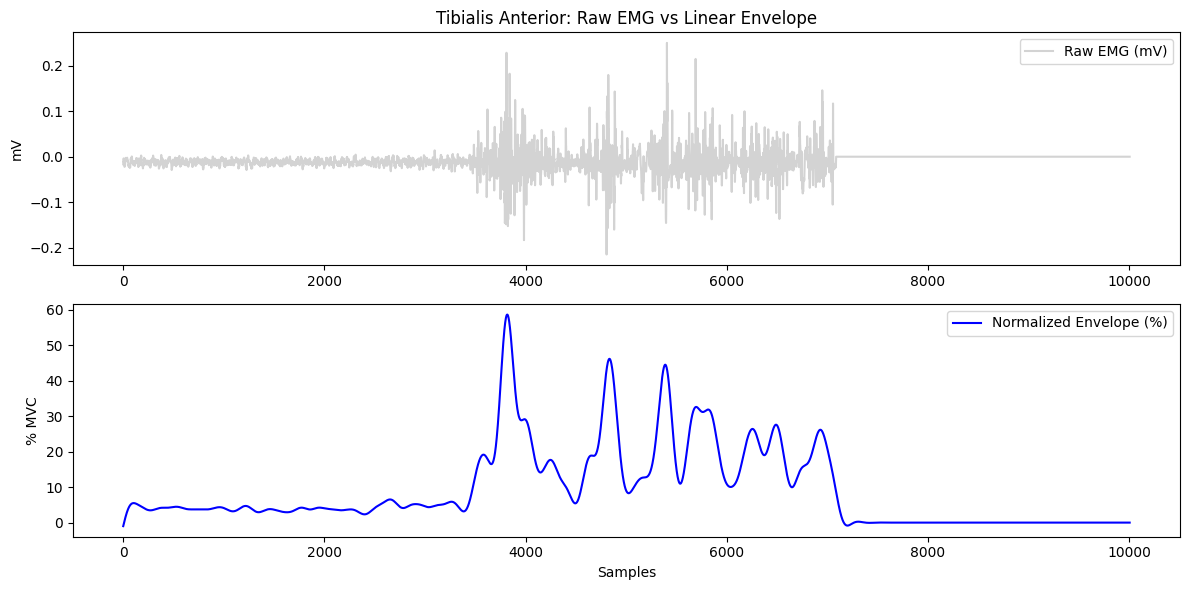

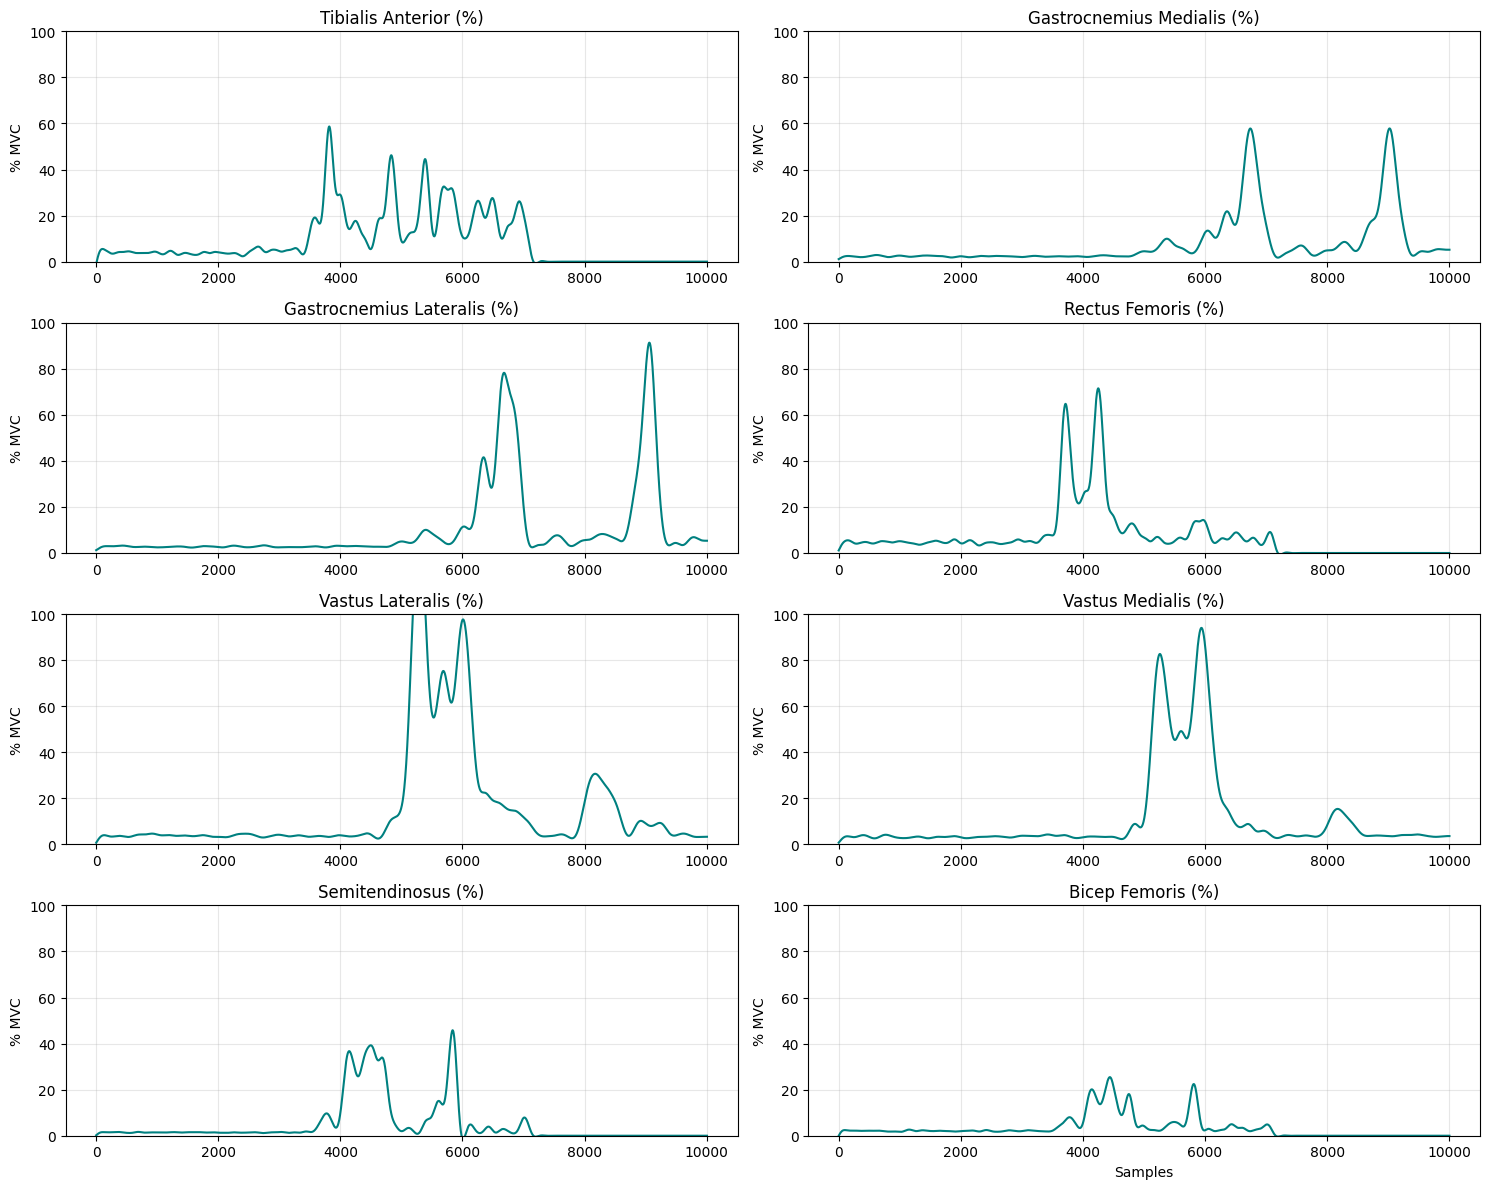

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the processed data and a sample of raw data
df_processed = pd.read_csv('processed_normalized_emg.csv')
# Load raw Tibialis Anterior for comparison (Column 0 in stw4.csv)
df_raw = pd.read_csv(EMG_FILE, skiprows=2, header=None, usecols=[0])
raw_emg = pd.to_numeric(df_raw[0], errors='coerce').fillna(0).values

# 2. Plot Comparison (Raw vs Envelope)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(raw_emg, color='lightgray', label='Raw EMG (mV)')
plt.title('Tibialis Anterior: Raw EMG vs Linear Envelope')
plt.ylabel('mV')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_processed['Tibialis Anterior (%)'], color='blue', label='Normalized Envelope (%)')
plt.ylabel('% MVC')
plt.xlabel('Samples')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot All Muscles (Normalized Envelopes)
muscles = df_processed.columns
rows = (len(muscles) + 1) // 2
plt.figure(figsize=(15, rows * 3))

for i, muscle_col in enumerate(muscles):
    plt.subplot(rows, 2, i + 1)
    plt.plot(df_processed[muscle_col], color='teal')
    # Clean up title for display
    title = muscle_col.replace('_Envelope_Normalized', '')
    plt.title(title)
    plt.ylim(bottom = 0, top = 100)
    plt.ylabel('% MVC')
    plt.grid(True, alpha=0.3)

plt.xlabel('Samples')
plt.tight_layout()
plt.show()